### Example: Moving-Horizon Simulataneous Input-and-State Estimation

In [1]:
import numpy as np
import cvxpy as cp 

###### define dimmensions ######
N_DATA = 100
HORIZON_LENGTH = 100 # horizon
N_MASSES = 4

n = 2*N_MASSES - 1 # number of states
m = 2 # number of inputs
p = 2 # number of outputs
c = 2*m # number of constraints

################################


**Define system parameters**

In [2]:
import numpy as np
from scipy.linalg import expm, sqrtm
from mh_sise.model_utils import lumped_mass_parameters



# Example parameters
inertia, stiffness, damping = lumped_mass_parameters(
    N=N_MASSES, 
    length=1 * N_MASSES, 
    d_inner=1E-3, 
    d_outer=1.2E-3, 
    density=7850, 
    G=80E9, 
    damping_ratio=0.01, 
    natural_frequency=10
)

print('Mass moment of inertia:', inertia, 'kg·m²')
print('Stiffness coefficient:', stiffness, 'N·m/rad')
print('Damping coefficient:', damping, 'N·m/(rad/s)')

I = inertia * np.ones(N_MASSES)
K = stiffness * np.ones(N_MASSES-1)
C = damping * np.ones(N_MASSES-1)

D = np.zeros(N_MASSES) # friction damping
D[0] = 0.1

# Covariande matrices for noise (assumed zero-mean Gaussian noise)
Q_v = 0.001 * np.eye(p)  # Measurement noise covariande
Q_w = 0.001 * np.eye(n)  # Process noise covariande

Mass moment of inertia: 3.3095736127772373e-09 kg·m²
Stiffness coefficient: 0.008432034682234997 N·m/rad
Damping coefficient: 0.0010851061025499143 N·m/(rad/s)


**Convert to state-space model**

In [3]:
from mh_sise.model_utils import lumped_mass_ss
from scipy.signal import cont2discrete

# contonuous-time model
Ac, Bc, Cc, Dc = lumped_mass_ss(N_MASSES=N_MASSES, I=I, K=K, C=C, D=D, sensor_loc=0)

# Discrete-time model
ts = 0.001
dsys = cont2discrete((Ac, Bc, Cc, Dc), ts, method='zoh')
Ad, Bd, Cd, Dd, dt_discrete = dsys

**Simulate**

In [4]:
from scipy.signal import dlsim
from mh_sise.model_utils import mexican_hat

n_states, n_inputs = np.shape(Bd)
n_outputs = np.shape(Cd)[0]

#initialize signals
usim = np.zeros([N_DATA, n_inputs])
usim[:,0] = 0.5 * mexican_hat(N_DATA, 10, N_DATA/2)
usim[:,1] = mexican_hat(N_DATA, 20, N_DATA/4) + mexican_hat(N_DATA, 20, 3/4*N_DATA)

tsim, ysim, xsim = dlsim((Ad, Bd, Cd, Dd, dt_discrete), usim)

**Plot data**

(-1.0, 1.0)

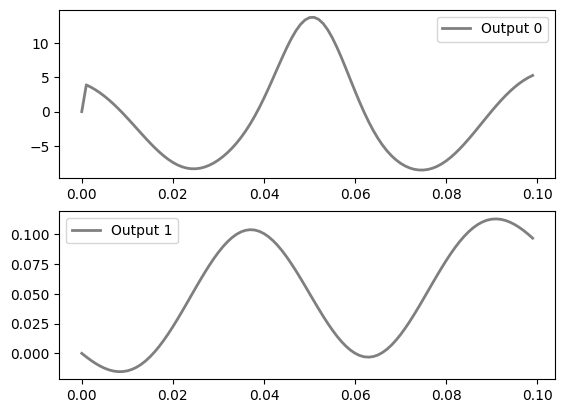

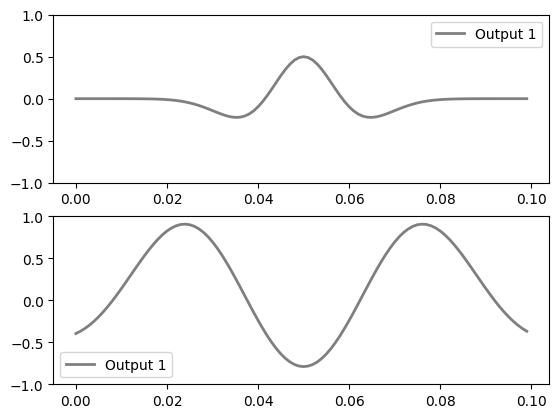

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(n_outputs)
for k in range(n_outputs):
     axs[k].plot(tsim, ysim[:,k].T,'k', alpha=0.5, linewidth=2, label=f'Output {k}')
     axs[k].legend()

fig2, axs2 = plt.subplots(2)
axs2[0].plot(tsim, usim[:,0].T,'k', alpha=0.5, linewidth=2, label=f'Output {k}')
axs2[0].set_ylim([-1, 1])
axs2[0].legend()
axs2[1].plot(tsim, usim[:,1].T,'k', alpha=0.5, linewidth=2, label=f'Output {k}')
axs2[1].legend()
axs2[1].set_ylim([-1, 1])

**Define problem**

In [6]:
tsim = tsim.T
ysim = ysim.T
xsim = xsim.T

#- define variables
x_var = cp.Variable((n, HORIZON_LENGTH), name='xvar')
u_var = cp.Variable((m, HORIZON_LENGTH), name='uvar')
v_var = cp.Variable((p, HORIZON_LENGTH), name='vvar')
w_var = cp.Variable((n, HORIZON_LENGTH), name='vvar')

# define parameters
Q_v_sqrt = cp.Parameter((p, p), name='Q_v_sqrt')
Q_w_sqrt = cp.Parameter((n, n), name='Q_w_sqrt')
L = cp.Parameter((m, m), name='L')
y = cp.Parameter((p,HORIZON_LENGTH), name='y')
x0 = cp.Parameter(n, name='x0')
u0 = cp.Parameter(n, name='u0')
A = cp.Parameter((n,n), name='A')
B = cp.Parameter((n,m), name='B')
C = cp.Parameter((p,n), name='C')

# define objective
objective = cp.Minimize(
    cp.sum_squares( Q_w_sqrt@w_var[:,:HORIZON_LENGTH] ) + cp.sum_squares( Q_v_sqrt@v_var[:,:HORIZON_LENGTH] ) + cp.sum_squares( L@u_var[:,:HORIZON_LENGTH] )  
)

#dpp (diciplined programming principle) check
print(objective.is_dcp(dpp=True))

# define constraints
constraints = [
    w_var[:,0] == x_var[:,0] - x0,
    w_var[:,1:] == x_var[:,1:HORIZON_LENGTH] - A@x_var[:,0:HORIZON_LENGTH-1] - B@u_var[:,0:HORIZON_LENGTH-1],
    v_var[:,:HORIZON_LENGTH] == y[:,:HORIZON_LENGTH] - C@x_var[:,:HORIZON_LENGTH],
    cp.abs(u_var) <= 1
]

# define problem
problem = cp.Problem(objective, constraints)

True


**Solve problem**

In [7]:
import time

# assign cvx parameter values
Q_v_sqrt.value = sqrtm(Q_v)
Q_w_sqrt.value = sqrtm(Q_w)
A.value = Ad
B.value = Bd
C.value = Cc
x0.value = np.zeros(n)
x0.value = np.zeros(n)
L.value = 0.001 * np.eye(m)
y.value = ysim

t0 = time.time()
solution = problem.solve()
t1 = time.time()

print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))
print('Objective function value: %.6f\n' % solution)


CVXPY
Solve time: 39.467 ms
Objective function value: 0.000048



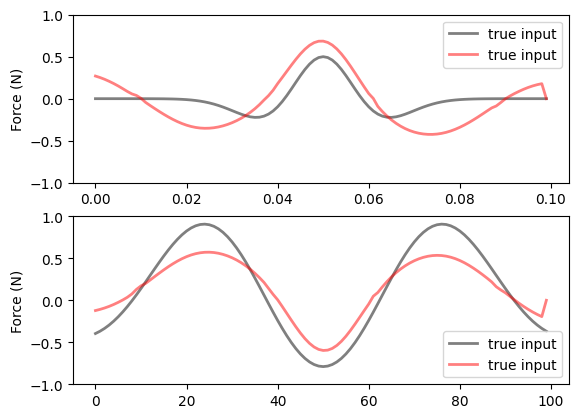

In [8]:
import matplotlib.pyplot as plt

# plot result
fig, axs = plt.subplots(2)
axs[0].plot(tsim, usim[:,0],'k', alpha=0.5, linewidth=2, label='true input')
axs[0].plot(tsim, u_var.value[0,:].T,'r', alpha=0.5, linewidth=2, label='true input')
axs[0].set_ylabel('Force (N)')
axs[0].set_ylim([-1, 1])
axs[0].legend()

axs[1].plot(usim[:,1].T,'k', alpha=0.5, linewidth=2, label='true input')
axs[1].plot(u_var.value[1,:].T,'r', alpha=0.5, linewidth=2, label='true input')
axs[1].set_ylabel('Force (N)')
axs[1].set_ylim([-1, 1])
axs[1].legend()

**cvxgen**

<span style="color:red">There are issues here !?</span>

In [9]:
from cvxpygen import cpg

cpg.generate_code(problem, code_dir='sisegen')

Generating code with CVXPYgen ...
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 3100, constraints m = 2600
          nnz(P) + nnz(A) = 18137
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

Getting workspace from OSQP object... 				[done]
Creating target directories... 					[done]
Copying OSQP sources... 					[done]
Generating customized code... 					[done]
Creating project...
[

ValueError: No Python module generated! Some errors have occurred.